<a href="https://colab.research.google.com/github/GoKarolis/ML_training_project/blob/main/kg_red_wine_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Wine Quality 


---


by GoKarolis






***Inspiration:***

To use machine learning to determine which physiochemical properties make a wine 'good'!


***Goals:***


*   Create a ML model which finds out the quality of wine
*   Find out what properties 'Good' wine must have
* Find out what properties make wine 'Bad'





***Raw dataset can be found here:***

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

# Init

In [268]:
%matplotlib inline

In [269]:
# ?display
# ??display

In [270]:
!pip install shap
!pip install eli5

In [271]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score
import eli5
from eli5.sklearn import PermutationImportance
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [272]:
# Set Seaborn colors
sns.set_palette("Set2")

In [273]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [274]:
# wine_data == data
%time  data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/winequality-red.csv')

CPU times: user 8.94 ms, sys: 1.07 ms, total: 10 ms
Wall time: 11.6 ms


# **1. Exploratory data analysis**

# 1.1. Shape

In [275]:
data.shape

(1599, 12)

# 1.2. Descriptive statistics

In [276]:
data.isnull().sum()
#data.isna().sum() 

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [277]:
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [278]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# 1.3. Data types and more information about the data

In [279]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [280]:
data['quality'].value_counts().sort_index(ascending=False)

8     18
7    199
6    638
5    681
4     53
3     10
Name: quality, dtype: int64

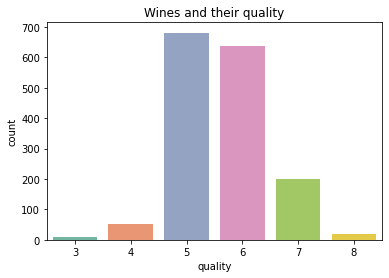

In [281]:
plt.title('Wines and their quality')
sns.countplot(data['quality'])
plt.show()


# **2. Feature engineering**

In [282]:
# data = data.drop(['free sulfur dioxide', 'pH', 'fixed acidity'], axis=1)

# **3. Feature pre-processing**

In [283]:
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
data['quality'] = pd.cut(data['quality'], bins = bins, labels = group_names)

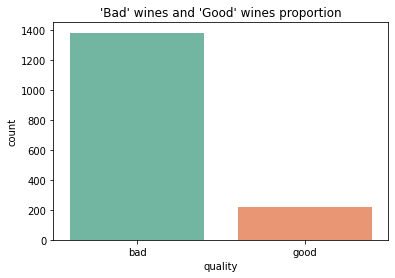

bad     1382
good     217
Name: quality, dtype: int64

In [284]:
plt.title('\'Bad\' wines and \'Good\' wines proportion')
sns.countplot(data['quality'])
plt.show()
data['quality'].value_counts()

In [285]:
label_quality = LabelEncoder()

data['quality'] = label_quality.fit_transform(data['quality'])

X = data.drop('quality', axis = 1)
y = data['quality']



---


Permutation importance 

In [286]:
#Permutation importance 
#Why not RF FI https://explained.ai/rf-importance/
#Alternative: rfpimp


PI_data = data.copy()
PI_y = (PI_data['quality'] == "good")
feature_names = [i for i in PI_data.columns if PI_data[i].dtype in [np.int64]]
PI_X = data[feature_names]
PI_train_X, PI_val_X, PI_train_y, PI_val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=1000,
                                  random_state=0).fit(PI_train_X, PI_train_y)

In [287]:
perm = PermutationImportance(my_model, random_state=1).fit(PI_val_X,PI_val_y)
eli5.show_weights(perm, feature_names = PI_val_X.columns.tolist())

Weight,Feature
0.0290 ± 0.0108,sulphates
0.0255 ± 0.0150,alcohol
0.0075 ± 0.0089,volatile acidity
0.0050 ± 0.0089,density
0.0045 ± 0.0139,chlorides
0.0020 ± 0.0066,citric acid
0.0005 ± 0.0049,residual sugar
-0.0000 ± 0.0114,total sulfur dioxide
-0.0005 ± 0.0097,pH
-0.0005 ± 0.0097,fixed acidity




---


Train test split

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



---


Data normalization

https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [289]:
trans = MinMaxScaler()
X_train_norm = trans.fit_transform(X_train)
X_train_norm = DataFrame(X_train_norm)

In [290]:
X_train_norm.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,0.329530,0.281205,0.272471,0.113389,0.127626,0.222031,0.143665,0.492216,0.450118,0.177929,0.310477
std,0.152588,0.122791,0.195448,0.098342,0.082358,0.153933,0.116403,0.136266,0.121272,0.107119,0.161953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.221239,0.191781,0.100000,0.068493,0.098497,0.089552,0.056537,0.410059,0.370079,0.110429,0.169231
50%,0.292035,0.273973,0.260000,0.089041,0.113523,0.194030,0.113074,0.494126,0.448819,0.153374,0.276923
75%,0.407080,0.356164,0.430000,0.116438,0.131886,0.298507,0.201413,0.570852,0.519685,0.220859,0.415385
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




---


Data standardization:

In [291]:
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

num_cols = X_train_stand.columns.values.tolist()

for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])

    X_train_stand[i] = scale.transform(X_train_stand[[i]])
   
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [292]:
X_train_stand.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03,1.279000e+03
mean,-1.239561e-16,4.180480e-16,1.266904e-16,1.736080e-17,-1.854133e-16,-9.478996e-17,-8.038049e-17,2.558044e-14,-1.375149e-15,4.398358e-16,5.815867e-16
std,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00,1.000391e+00
min,-2.160453e+00,-2.291000e+00,-1.394630e+00,-1.153456e+00,-1.550257e+00,-1.442950e+00,-1.234688e+00,-3.613585e+00,-3.713085e+00,-1.661679e+00,-1.917831e+00
25%,-7.099747e-01,-7.285451e-01,-8.827838e-01,-4.567030e-01,-3.538207e-01,-8.609621e-01,-7.487957e-01,-6.031534e-01,-6.602541e-01,-6.303756e-01,-8.724843e-01
50%,-2.458216e-01,-5.892147e-02,-6.383064e-02,-2.476770e-01,-1.713135e-01,-1.819756e-01,-2.629030e-01,1.402550e-02,-1.071561e-02,-2.293130e-01,-2.072638e-01
75%,5.084274e-01,6.107022e-01,8.063071e-01,3.102432e-02,5.175080e-02,4.970108e-01,4.963043e-01,5.773023e-01,5.738691e-01,4.009282e-01,6.480197e-01
max,4.395710e+00,5.856087e+00,3.723828e+00,9.019142e+00,1.059661e+01,5.055920e+00,7.359539e+00,3.727879e+00,4.536054e+00,7.677349e+00,4.259217e+00




---


SMOTE

In [293]:
sm = SMOTE(random_state=2)
X_train_SM, y_train_SM = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_SM.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_SM.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_SM==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_SM==0)))

After OverSampling, the shape of train_X: (2218, 11)
After OverSampling, the shape of train_y: (2218,) 

After OverSampling, counts of label '1': 1109
After OverSampling, counts of label '0': 1109


In [294]:
X_train_SM = DataFrame(X_train_norm)
X_train_SM.info

<bound method DataFrame.info of             0         1     2   ...        8         9         10
0     0.362832  0.390411  0.31  ...  0.582677  0.226994  0.492308
1     0.132743  0.061644  0.40  ...  0.401575  0.134969  0.538462
2     0.557522  0.184932  0.47  ...  0.440945  0.233129  0.215385
3     0.371681  0.386986  0.26  ...  0.456693  0.061350  0.153846
4     0.336283  0.626712  0.15  ...  0.496063  0.073620  0.230769
...        ...       ...   ...  ...       ...       ...       ...
1274  0.398230  0.328767  0.00  ...  0.346457  0.159509  0.307692
1275  0.318584  0.352740  0.10  ...  0.433071  0.233129  0.384615
1276  0.230088  0.342466  0.06  ...  0.606299  0.104294  0.169231
1277  0.292035  0.054795  0.35  ...  0.456693  0.263804  0.538462
1278  0.106195  0.116438  0.26  ...  0.511811  0.104294  0.784615

[1279 rows x 11 columns]>

# **4. Building machine learning model**

4.1. Out of the box models performance comparison:

LR: 0.340278 (0.098479)
LDA: 0.446129 (0.145735)
KNN: 0.302628 (0.083967)
SVM: 0.342558 (0.099954)
CART: 0.554743 (0.076590)
NB: 0.515006 (0.061597)
RF: 0.595161 (0.092896)
XGB: 0.517705 (0.096076)
...................................................


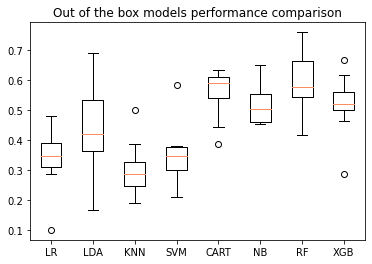

In [295]:
models = [('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
          ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC(gamma='auto')),
          ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('RF', RandomForestClassifier()),
          ('XGB', XGBClassifier())]

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
print("...................................................")
plt.boxplot(results, labels=names)
plt.title('Out of the box models performance comparison')
plt.show()

In [296]:
# print(results)

4.2 Out of the box models performance comparison **with data standartization**:

LR: 0.392074 (0.108304)
LDA: 0.446129 (0.145735)
KNN: 0.473660 (0.091131)
SVM: 0.386748 (0.113406)
CART: 0.576083 (0.082509)
NB: 0.523567 (0.058323)
RF: 0.603268 (0.102271)
XGB: 0.523244 (0.099876)
...................................................


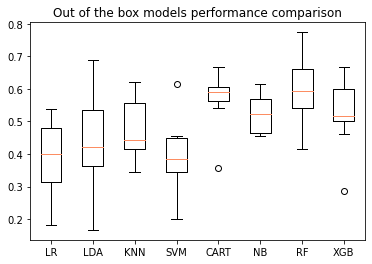

In [297]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train_stand, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
print("...................................................")
plt.boxplot(results, labels=names)
plt.title('Out of the box models performance comparison')
plt.show()

4.3 Out of the box models performance comparison **with data normalization**:

LR: 0.276363 (0.099218)
LDA: 0.446129 (0.145735)
KNN: 0.483611 (0.064785)
SVM: 0.000000 (0.000000)
CART: 0.559290 (0.082155)
NB: 0.523567 (0.058323)
RF: 0.599831 (0.094726)
XGB: 0.517705 (0.096076)
...................................................


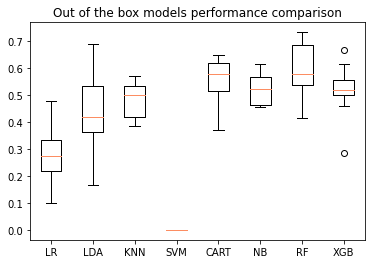

In [298]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train_norm, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
print("...................................................")
plt.boxplot(results, labels=names)
plt.title('Out of the box models performance comparison')
plt.show()

4.4 Out of the box models performance comparison **with SMOTE**:

LR: 0.276363 (0.099218)
LDA: 0.446129 (0.145735)
KNN: 0.483611 (0.064785)
SVM: 0.000000 (0.000000)
CART: 0.556497 (0.079224)
NB: 0.523567 (0.058323)
RF: 0.602339 (0.106041)
XGB: 0.517705 (0.096076)
...................................................


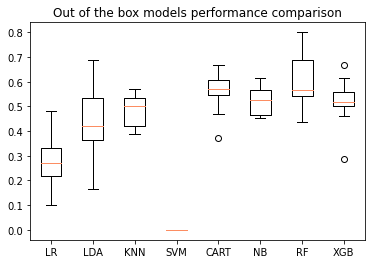

In [299]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train_SM, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
print("...................................................")
plt.boxplot(results, labels=names)
plt.title('Out of the box models performance comparison')
plt.show()

4.5 Models performance comparison **after hyperparameter tuning**:

LR: 0.340278 (0.098479)
LDA: 0.446129 (0.145735)
KNN: 0.536420 (0.051816)
SVM: 0.342558 (0.099954)
CART: 0.570262 (0.089775)
NB: 0.515006 (0.061597)
RF: 0.620038 (0.103713)
XGB: 0.599934 (0.111658)
...................................................


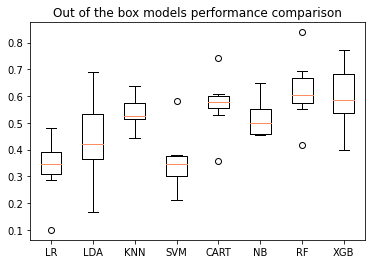

In [300]:
models = [('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
          ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier(n_neighbors=1)),
          ('SVM', SVC(gamma='auto')),
          ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('RF', RandomForestClassifier(max_features=4,n_estimators=250)),
          ('XGB', XGBClassifier(n_estimators=1000,learning_rate=0.1,max_depth=4,early_stopping_rounds=5,subsample=0.8))]

results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
 
print("...................................................")
plt.boxplot(results, labels=names)
plt.title('Out of the box models performance comparison')
plt.show()



---


# **Drafts:**

# k-Nearest Neighbour

In [301]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       273
           1       0.53      0.21      0.30        47

    accuracy                           0.86       320
   macro avg       0.70      0.59      0.61       320
weighted avg       0.83      0.86      0.83       320



In [302]:
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

F1 score: 0.303030


In [303]:
# from sklearn.preprocessing import PolynomialFeatures


# # calculate change in number of features
# num_features = list()
# degrees = [i for i in range(1, 6)]
# for d in degrees:
# 	# create transform
# 	trans = PolynomialFeatures(degree=d)
# 	# fit and transform
# 	data = trans.fit_transform(X)
# 	# record number of features
# 	num_features.append(data.shape[1])
# 	# summarize
# 	print('Degree: %d, Features: %d' % (d, data.shape[1]))
# # plot degree vs number of features
# plt.plot(degrees, num_features)
# plt.show()

In [304]:
# # polynomial features transform


# def get_models():
# 	models = dict()
# 	for d in range(1,5):
# 		# define the pipeline
# 		trans = PolynomialFeatures(degree=d)
# 		model = KNeighborsClassifier()
# 		models[str(d)] = Pipeline(steps=[('t', trans), ('m', model)])
# 	return models

# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# 	return scores


# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X, y)
# 	results.append(scores)
# 	names.append(name)
# 	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.show()

# Decision Tree

In [305]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       273
           1       0.55      0.57      0.56        47

    accuracy                           0.87       320
   macro avg       0.74      0.75      0.74       320
weighted avg       0.87      0.87      0.87       320



In [306]:
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

F1 score: 0.562500


In [307]:
"""
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
"""

"\n# define pipeline\nmodel = DecisionTreeClassifier()\nover = SMOTE(sampling_strategy=0.5)\nunder = RandomUnderSampler(sampling_strategy=0.1)\nsteps = [('over', over), ('under', under), ('model', model)]\npipeline = Pipeline(steps=steps)\n"

In [308]:
"""
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=1000, n_features=11, n_redundant=1,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define pipeline
model = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
print('Mean f1 score: %.3f' % mean(scores))
"""

"\n# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling\nfrom numpy import mean\nfrom sklearn.datasets import make_classification\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import RepeatedStratifiedKFold\nfrom sklearn.tree import DecisionTreeClassifier\nfrom imblearn.pipeline import Pipeline\nfrom imblearn.over_sampling import SMOTE\nfrom imblearn.under_sampling import RandomUnderSampler\n# define dataset\nX, y = make_classification(n_samples=1000, n_features=11, n_redundant=1,\n\tn_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)\n# define pipeline\nmodel = DecisionTreeClassifier()\nover = SMOTE(sampling_strategy=0.1)\nunder = RandomUnderSampler(sampling_strategy=0.5)\nsteps = [('over', over), ('under', under), ('model', model)]\npipeline = Pipeline(steps=steps)\n# evaluate pipeline\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\nscores = cross_val_score(pipeline, X, y, s

In [309]:
# #Smote Decision tree

# X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
# pipeline = Pipeline(steps=steps)

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
# print('Mean f1 score: %.3f' % mean(scores))

# Logistic regression

In [310]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

print(classification_report(y_test,lr_predict))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       273
           1       0.62      0.21      0.32        47

    accuracy                           0.87       320
   macro avg       0.75      0.60      0.62       320
weighted avg       0.84      0.87      0.84       320



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# GaussianNB

In [311]:
# nb_classifier = GaussianNB()

# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# gs_NB = GridSearchCV(estimator=nb_classifier, 
#                  param_grid=params_NB, 
#                  cv=cv_method,   # use any cross validation technique 
#                  verbose=1, 
#                  scoring='f1') 
# gs_NB.fit(X_train, y_train)

# gs_NB.best_params_

# Random forest

In [312]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       273
           1       0.72      0.55      0.63        47

    accuracy                           0.90       320
   macro avg       0.82      0.76      0.79       320
weighted avg       0.90      0.90      0.90       320



In [313]:
score = f1_score(y_test, y_pred, average='binary')
print('F-Measure: %.3f' % score)

F-Measure: 0.627


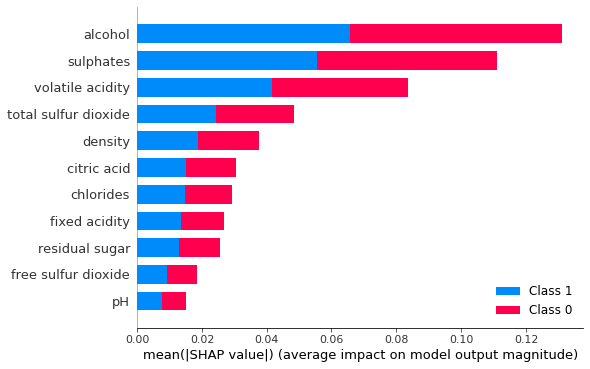

In [314]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)


shap.summary_plot(shap_values, X)

In [315]:
# shap.dependence_plot('alcohol', shap_values, X)

# XGBOOST

standard deviation of absolute error (STD of AE)

In [316]:
# https://www.kaggle.com/alexisbcook/xgboost

xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.1,
                    max_depth=4, 
                    early_stopping_rounds=5,
                    subsample=0.8,
                    #colsample_bytree = 0.4,
                    #gamma=1
                    )  
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
# print(accuracy_score(y_test,y_pred))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       273
           1       0.76      0.68      0.72        47

    accuracy                           0.92       320
   macro avg       0.85      0.82      0.84       320
weighted avg       0.92      0.92      0.92       320



In [317]:
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

F1 score: 0.719101


In [318]:
print(xgb.feature_importances_)

[0.07431623 0.09620414 0.07065256 0.0680801  0.07144342 0.08602658
 0.08729184 0.05966264 0.0660698  0.12157638 0.19867633]


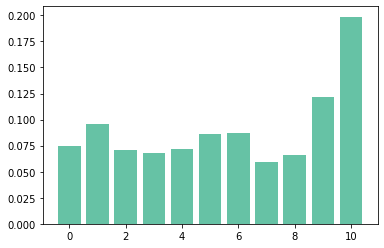

In [319]:
# plot
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [320]:
# plot_importance(xgb)
# plt.show()

In [321]:
# # use feature importance for feature selection
# from numpy import loadtxt
# from numpy import sort
# from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import SelectFromModel


# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# # Fit model using each importance as a threshold
# thresholds = sort(xgb.feature_importances_)
# for thresh in thresholds:
# 	# select features using threshold
# 	selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
# 	select_X_train = selection.transform(X_train)
# 	# train model
# 	selection_model = XGBClassifier()
# 	selection_model.fit(select_X_train, y_train)
# 	# eval model
# 	select_X_test = selection.transform(X_test)
# 	y_pred = selection_model.predict(select_X_test)
# 	predictions = [round(value) for value in y_pred]
# 	accuracy = accuracy_score(y_test, predictions)
# 	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

# Conclusion. What characteristics make the wine 'good'?

# Notes:

boosted stumps
Hyperparameter tuning visiems
Models append: listą pasirašyti
Balansuoti: pasverti, oversamplinti, smote
Sunormalizuoti data: 0 vidurkis, 1 deviation
Pagamint polinomial interactions: polinomial proprocessor
Feature importance: Shap values
Pradžioj pasižiūrėti feature importance su RF
F1 score - to go.
Parodyti rezultatų gerėjimą.


To do:
Run all models on Standardized, Normalized and Raw data

https://machinelearningmastery.com/



Requirements
    Do exploratory data analysis.
    Do feature engineering.
    Do feature preprocessing.
    Build a machine learning model.
    Explore your model results.
Bonus Points
    Move your final model to a Python module.
    Compare multiple machine learning models.
    Do hyperparameter tuning.
    Deploy the model on your own machine.
    Deploy the model on external service.